In [25]:
from pprint import pprint
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, StateGraph, START
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
llm= ChatOpenAI()
embeddings= OpenAIEmbeddings()

In [27]:
# Used to build retriever

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=40
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [28]:
# Converting retrieval into tool
from langchain.tools.retriever import create_retriever_tool
retriever_tool= create_retriever_tool(
    retriever,   #tool
    "retrieve_blog_posts", # name of the tool
    "search and return informationabout Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attackes on LLMs.", #description of the tool
    
)
tools= [retriever_tool]

In [29]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader checking if a document is relevant to a user's question. The check has to be done very strictly.
If the document has words or meanings related to the question, mark it as relevant.
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/Users/sunilyadav/AI/Agents/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


binary_score='no'


In [30]:
question= "who is this sunil?"

In [31]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [32]:
prompt = hub.pull("rlm/rag-prompt")    # This is prompt which we are getting from langchain hub.

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question= "what is the AI agent?"
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/Users/sunilyadav/AI/Agents/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The AI agent is part of an autonomous system where LLM functions as the agent's brain. It plays a role in planning, memory utilization, and calling external APIs for additional information. The agent learns from past actions, breaks down tasks into subgoals, and continuously refines its approach.


In [33]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

/Users/sunilyadav/AI/Agents/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


GradeHallucinations(binary_score='yes')

In [34]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

/Users/sunilyadav/AI/Agents/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


GradeAnswer(binary_score='yes')

##### Here above what actually we did...
##### we first check our generated output with relevant doc and then with the question (this double check making it more effective.)

### Re-Write the query (if everything not working)

In [35]:
### Question Re-writer

# Prompt
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval doc.
You are given both a question and a document.
- First, check if the question is relevant to the document by identifying a connection or relevance between them.
- IF there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.
- IF no relevance is found, simply return 'question not relevant.'
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", """Here is the initial question: \n\n {question} \n,
        Here is the document: \n\n {document} \n,
        Formulate an improved question. If possible other return 'question not relevant.'"""),
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()


In [36]:
question= "who is the current president of the USA"

In [37]:
question_rewriter.invoke({'question':question, 'document': docs})

'Improved question: \nWhat are some examples of proof-of-concepts demos involving Large Language Models (LLM) in autonomous agent systems?'

In [38]:
# This data is moving through entire graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        filter_documents: list of filter_documents
        unfilter_documents: list of unfilter_documents
    """

    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [80]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]    # for grading the document it is taking the question and the document.

    # Score each doc
    filtered_docs = []
    unfiltered_docs= []
    
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": doc}      # Here we are checking relevancy
        ) 
        grade = score.binary_score      # getting binary score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)> 1:     # in this case we return the unfiltered_docs bec it will require the transform the query, bcz we have unfiltered docs. 
        return {'unfilter_document': unfiltered_docs, 'filtered_document': [], 'question': question} 
    else:   
        return {"filter_document": filtered_docs, 'unfilter_document':[], "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question. here query is only transformed when query has at least little relevance with the document.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"------RESPONSE----- {response}")
    if response == 'question not relevant':
        print("------QUESTION IS NOT AT ALL RELEVANT------")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:
        return {"documents":documents,"question":response}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    unfiltered_documents = state['unfilter_document']
    filtered_documents = state["filter_document"]

    if unfiltered_documents:
        print(
            "---DECISION: ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    elif filtered_documents:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    else:
        # Fallback: no relevant or irrelevant documents, end the process
        print("---DECISION: NO DOCUMENTS AVAILABLE, END---")
        return "query_not_at_all_relevant"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        return "not supported"

def decide_to_generate_after_transformation(state): # Here if question is not relevant then simply we stop the process. othervise we again go to Retriever.
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [81]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("doc_vector_retriever", retrieve)  # retrieve
workflow.add_node("gradeing_generated_documents", grade_documents)  # grade documents
workflow.add_node("content_generator", generate)  # generatae
workflow.add_node("transform_user_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "doc_vector_retriever")
workflow.add_edge("doc_vector_retriever", "gradeing_generated_documents")
workflow.add_conditional_edges(
    "gradeing_generated_documents",
    decide_to_generate,
    {
        "transform_query": "transform_user_query",
        "generate": "content_generator",
    }
)
workflow.add_edge("transform_user_query", "doc_vector_retriever")
workflow.add_conditional_edges(
    "content_generator",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "transform_user_query",
    }
)
workflow.add_conditional_edges(
    "transform_user_query",
    decide_to_generate_after_transformation,
    {
        "retriever": "doc_vector_retriever",
        "query_not_at_all_relevant":END
    }
)

# Compile
app = workflow.compile()

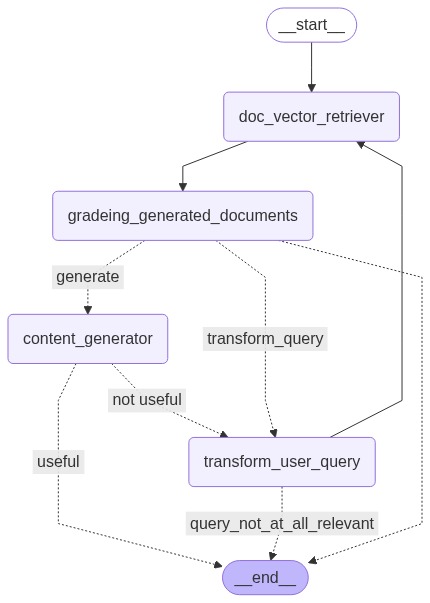

In [82]:
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [83]:
# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'doc_vector_retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'gradeing_generated_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'content_generator':"
'\n---\n'
('Short-term memory is used for in-context learning, allowing the model to '
 'acquire new information, while long-term memory lets the agent retain and '
 'recall a vast amount of information for extended periods. The long-term '
 'memory can leverage an external vector store for efficient and fast '
 'retrieval of stored data. These memory components play a crucial role in the '
 'operation of autonomous agents powered by large language models.')


In [84]:
inputs = {"question": "Explain how chain of thought prompting works?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'doc_vector_retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'gradeing_generated_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'content_generator':"
'\n---\n'
('Chain of thought prompting works by instructing the model to "think step by '
 'step" to decompose hard tasks into smaller and simpler steps. This approach '
 'transforms big tasks into multiple manageable tasks, shedding light on the '
 "model's thinking process. By exploring multiple reasoning possibilities at "
 'each step, it allows for a more thorough analysis and interpretation of '
 'complex tasks.')


In [85]:
# Run
inputs = {"question": "who is a prompt engineering?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'doc_vector_retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'gradeing_generated_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'content_generator':"
'\n---\n'
('Prompt Engineering, also known as In-Context Prompting, refers to methods '
 'for communicating with language models like LLM to guide their behavior for '
 'specific outcomes without updating model weights. This field involves heavy '
 'experimentation and heuristics due to varying effects among models, focusing '
 'on alignment and model steerability. Prompt Engineering is specifically '
 'discussed in the context of autoregressive language models.')


In [86]:
# Run
inputs = {"question": "who is the first PM of India?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'doc_vector_retriever':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---


KeyError: 'filter_document'